In [1]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [2]:
KEYPOINT_COLOR = (0, 255, 0) # Green

def vis_keypoints(image, keypoints, color=KEYPOINT_COLOR, diameter=15):
    image = image.copy()

    for (x, y) in keypoints:
        cv2.circle(image, (int(x), int(y)), diameter, (0, 255, 0), -1)

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(image)



In [111]:
import os

def df_to_csv(df, save_dir, name_csv):
    """
    Lưu DataFrame vào tệp CSV.

    Args:
        df (pd.DataFrame): DataFrame chứa dữ liệu.
        save_dir (str): Đường dẫn thư mục lưu kết quả.
        name_csv (str): Tên tệp CSV.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    csv_path = os.path.join(save_dir, f'{name_csv}.csv')
    df.to_csv(csv_path, index=False)
    print(f'Đã lưu csv vào {csv_path}')

def clamp_keypoints(keypoints, width, height):
    clamped_keypoints = []
    for x, y, *rest in keypoints:
        clamped_x = max(0, min(x, width - 1))
        clamped_y = max(0, min(y, height - 1))
        clamped_keypoints.append((clamped_x, clamped_y, *rest))
    return clamped_keypoints

def prepare_keypoint_dict(txt_path, image_height, image_width):
    keypoint_dict = {}
    with open(txt_path) as f:
        lines = f.readlines()
    for line in lines:
        point = line.strip().split(' ')
        dict = {}
        if point[0] == '2' or point[0] == '3':
            keypoints = [(int(float(point[i]) * image_width), 
                    int(float(point[i + 1]) * image_height)) 
                    for i in range(1, len(point), 2)]
            dict = {f'{point[0]}':keypoints}
        keypoint_dict.update(dict)
    return keypoint_dict

def keypoint_yolo(transformed_keypoints, new_width, new_height):
    """
    Tính toán keypoints từ transformed_keypoints.

    Args:
        transformed_keypoints (list): Danh sách các điểm đã biến đổi.
        new_width (int): Chiều rộng mới của ảnh.
        new_height (int): Chiều cao mới của ảnh.

    Returns:
        list: Danh sách các keypoints đã chuẩn hóa.
    """
    keypoints = [((float(x) / new_height), 
                  (float(y) / new_width)) 
                  for x, y in transformed_keypoints]
    return keypoints

def create_output_directories(SAVE_DIR, subdir='random_add'):
    output_path = f'{SAVE_DIR}/{subdir}'
    os.makedirs(f'{output_path}/images', exist_ok=True)
    os.makedirs(f'{output_path}/labels', exist_ok=True)
    return output_path



In [134]:
import os
import cv2
import albumentations as A
import random
import numpy as np

def add_gaussian_light(DIR_SRC, image_path, SAVE_DIR):
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
    image_name = image_path.split('/')[-1]
    print(f'{DIR_SRC}/images/{image_path}')
    img = cv2.imread(f'{DIR_SRC}/images/{image_path}')
    image_height, image_width = img.shape[:2]
    if image_width <= 400 or image_height <= 400:
        img = cv2.resize(img, (image_height*5, image_width*5))
        image_height, image_width = img.shape[:2]
    keypoint_dict = prepare_keypoint_dict(txt_path=f'{DIR_SRC}/labels/{image_name[:-4]}.txt', 
                                          image_height=image_height, 
                                          image_width=image_width)

    light_center_x = random.randint(200, image_width - 200)
    light_center_y = random.randint(200, image_height - 200)
    light_radius = random.randint(150, 300)  
    mask_light = np.zeros((image_height, image_width), dtype=np.float32)
    cv2.circle(mask_light, (light_center_x, light_center_y), light_radius, 255, -1)
    blurred_mask_light = cv2.GaussianBlur(mask_light, (0, 0), sigmaX=light_radius * 2)  
    
    blurred_mask_light = blurred_mask_light / blurred_mask_light.max()

    light_intensity = random.uniform(0.5, 1.0)  
    light_effect = np.zeros_like(img, dtype=np.float32)
    
    for i in range(3):  
        channel = img[:, :, i].astype(np.float32) / 255.0
        light_channel = blurred_mask_light * light_intensity
        light_effect[:, :, i] = channel + light_channel

    final_result = np.clip(light_effect * 255.0, 0, 255).astype(np.uint8)
    

    output_path = f'{SAVE_DIR}/add_gaussian_light'
    if not os.path.exists(output_path):
        os.makedirs(f'{output_path}/images')
        os.makedirs(f'{output_path}/labels')

    output_path = create_output_directories(SAVE_DIR, subdir='add_gaussian_light')
    
    new_height, new_width, _ = final_result.shape
    keypoint_dict['2'] = clamp_keypoints(keypoints=keypoint_dict['2'], 
                                         height=new_height,
                                         width=new_width, 
                                         )
    keypoint_dict['3'] = clamp_keypoints(keypoints=keypoint_dict['3'], 
                                         height=new_height,
                                         width=new_width, 
                                         )
    keypoints1 = keypoint_yolo(keypoint_dict['2'], 
                               new_width=new_width, 
                               new_height=new_height)
    keypoints2 = keypoint_yolo(keypoint_dict['3'], 
                               new_width=new_width, 
                               new_height=new_height)

    save_path = f'{output_path}/images/{image_name[:-4]}light.jpg'
    txt_path = f'{output_path}/labels/{image_name[:-4]}light.txt'

    #luu keypoint và ảnh
    with open(txt_path, 'w') as f:
        text1 = '2 ' + ' '.join(f'{x} {y}' for x, y in keypoints1)
        text2 = '3 ' + ' '.join(f'{x} {y}' for x, y in keypoints2)
        f.write(text1 + '\n')
        f.write(text2)
    cv2.imwrite(save_path, final_result)
    file_name = save_path.split('/')[-1]

    return new_width, new_height, file_name, save_path, {
        'transform': {
            'light': [light_center_x, light_center_y, light_radius, light_intensity]
        }
    }

In [135]:
import os
import cv2
import albumentations as A
import random

def aug_random(DIR_SRC, image_path, SAVE_DIR):
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
    image_name = image_path.split('/')[-1]
    image = cv2.imread(f'{DIR_SRC}/images/{image_path}')
    image_height, image_width = image.shape[:2]
    keypoint_dict = prepare_keypoint_dict(txt_path=f'{DIR_SRC}/labels/{image_name[:-4]}.txt', 
                                          image_height=image_height, 
                                          image_width=image_width)

    augmentations = A.Compose([
        A.GaussNoise(),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ],  keypoint_params=A.KeypointParams(format='xy', remove_invisible=True),
        additional_targets={'image':'image',
                            'keypoints1': 'keypoints',
                            'keypoints2': 'keypoints'},
    )

    t = random.seed(42)
    keypoint_dict['2'] = clamp_keypoints(keypoints=keypoint_dict['2'], 
                                         height=image_height,
                                         width=image_width, 
                                         )
    keypoint_dict['3'] = clamp_keypoints(keypoints=keypoint_dict['3'], 
                                         height=image_height,
                                         width=image_width, 
                                         )
    transformed = augmentations(image=image, 
                                keypoints1=keypoint_dict['2'], 
                                keypoints2 = keypoint_dict['3']
                            )
    
    transformed_image = transformed['image']
    transformed_keypoints1 = transformed['keypoints1']
    transformed_keypoints2 = transformed['keypoints2']

    new_height, new_width = transformed_image.shape[:2]
    
    keypoints1 = keypoint_yolo(transformed_keypoints1, 
                               new_width=new_width, 
                               new_height=new_height)
    keypoints2 = keypoint_yolo(transformed_keypoints2, 
                               new_width=new_width, 
                               new_height=new_height)
    des_keypoint_dict = {'2': keypoints1,
                         '3': keypoints2}
    output_path = create_output_directories(SAVE_DIR, subdir='random_aug')
    
    save_path = f'{output_path}/images/{image_name[:-4]}random_aug.jpg'
    txt_path = f'{output_path}/labels/{image_name[:-4]}random_aug.txt'
    with open(txt_path, 'w') as f:
        text1 = '2 ' + ' '.join(f'{x} {y}' for x, y in keypoints1)
        text2 = '3 ' + ' '.join(f'{x} {y}' for x, y in keypoints2)
        f.write(text1 + '\n')
        f.write(text2)
    cv2.imwrite(save_path, transformed_image)
    file_name = save_path.split('/')[-1]
    return new_width, new_height, file_name, des_keypoint_dict, {
        'transform': f'random {random.seed(42)}'
    }

In [148]:
def rotate_augment(DIR_SRC, image_path, SAVE_DIR, rotate_degree):
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
    image_name = image_path.split('/')[-1]
    image = cv2.imread(f'{DIR_SRC}/images/{image_path}')
    image_height, image_width = image.shape[:2]
    keypoint_dict = prepare_keypoint_dict(txt_path=f'{DIR_SRC}/labels/{image_name[:-4]}.txt', 
                                          image_height=image_height, 
                                          image_width=image_width)
    
    augmentations = A.Compose([
        A.RandomBrightnessContrast(p=0.3),
        A.Affine(rotate=[rotate_degree, rotate_degree], p=1, mode=cv2.BORDER_CONSTANT, fit_output=True),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=True),
        additional_targets={'image': 'image', 'keypoints1': 'keypoints', 'keypoints2': 'keypoints'},
    )

    keypoint_dict['2'] = clamp_keypoints(keypoints=keypoint_dict['2'], 
                                         height=image_height,
                                         width=image_width, 
                                         )
    keypoint_dict['3'] = clamp_keypoints(keypoints=keypoint_dict['3'], 
                                         height=image_height,
                                         width=image_width, 
                                         )
    transformed = augmentations(image=image, 
                                keypoints1=keypoint_dict['2'], 
                                keypoints2 = keypoint_dict['3']
                            )
    
    transformed_image = transformed['image']
    transformed_keypoints1 = transformed['keypoints1']
    transformed_keypoints2 = transformed['keypoints2']

    new_height, new_width = transformed_image.shape[:2]
    
    keypoints1 = keypoint_yolo(transformed_keypoints1, 
                               new_width=new_width, 
                               new_height=new_height)
    keypoints2 = keypoint_yolo(transformed_keypoints2, 
                               new_width=new_width, 
                               new_height=new_height)
    des_keypoint_dict = {'2': keypoints1,
                         '3': keypoints2}

    output_path = create_output_directories(SAVE_DIR, subdir=str(rotate_degree))
    
    save_path = f'{output_path}/images/{image_name[:-4]}_rotate_{rotate_degree}.jpg'
    txt_path = f'{output_path}/labels/{image_name[:-4]}_rotate_{rotate_degree}.txt'
    with open(txt_path, 'w') as f:
        text1 = '2 ' + ' '.join(f'{x} {y}' for x, y in keypoints1)
        text2 = '3 ' + ' '.join(f'{x} {y}' for x, y in keypoints2)
        f.write(text1 + '\n')
        f.write(text2)
    cv2.imwrite(save_path, transformed_image)
    file_name = save_path.split('/')[-1]
    return des_keypoint_dict, new_width, new_height, image_name, file_name, rotate_degree

In [153]:
DIR_PATH = '/home/f88/khdl/thuylt15/aug_img_seg/dangkiem_yolo'
# /home/f88/khdl/thuylt15/aug_img_seg/dangkiem_yolo/images/0a4ab76a-20220107_125517_1641534917_8a2c.jpg
image_path = '0a4ab76a-20220107_125517_1641534917_8a2c.jpg'
txt_path = image_path.replace('images','labels').replace('jpg','txt')
rotate_augment(DIR_PATH, image_path, SAVE_DIR='test', rotate_degree=10)

({'2': [(0.37373029772329247, 0.410958904109589),
   (0.6795096322241682, 0.3270547945205479),
   (0.7737302977232925, 0.9041095890410958),
   (0.43712784588441334, 0.9375)],
  '3': [(0.112784588441331, 0.480736301369863),
   (0.19719789842381785, 0.4460616438356164),
   (0.36777583187390545, 0.410958904109589),
   (0.4329246935201401, 0.9413527397260274),
   (0.17478108581436078, 0.9623287671232876)]},
 2336,
 2855,
 '0a4ab76a-20220107_125517_1641534917_8a2c.jpg',
 '0a4ab76a-20220107_125517_1641534917_8a2c_rotate_10.jpg',
 10)

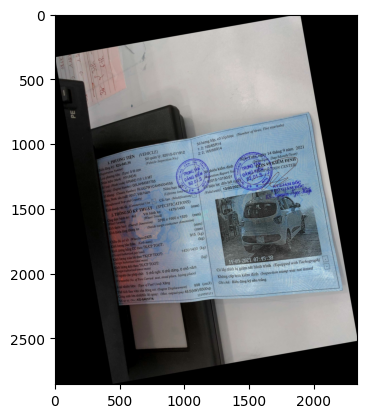

In [154]:
image_path = '/home/f88/khdl/thuylt15/aug_img_seg/augmentation_dangkiem/test/10/images/0a4ab76a-20220107_125517_1641534917_8a2c_rotate_10.jpg'
txt_path = image_path.replace('images','labels').replace('jpg','txt')
image = cv2.imread(image_path)
plt.imshow(image)
keypoint = prepare_keypoint_dict(txt_path, image.shape[1], image.shape[0])


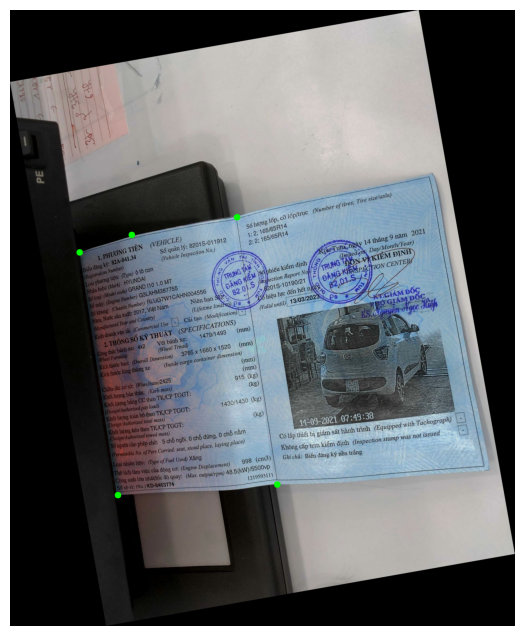

In [155]:
vis_keypoints(image, keypoint['3'])

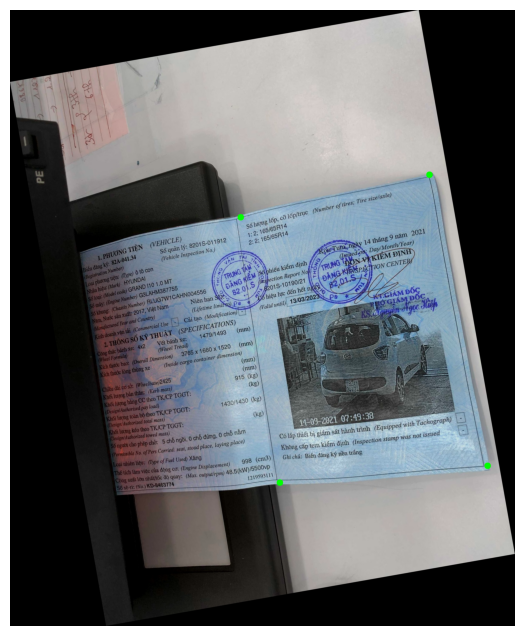

In [156]:
vis_keypoints(image, keypoint['2'])